In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/unsupervised_aav2`


In [2]:
using JLD2, BSON, Flux, PhageTree, PyPlot, BioSeqInt, Statistics, LinearAlgebra, StringDistances, DensityPlot, GaussianMixtures, Distributions

In [3]:
include("../analysis/utils.jl")

binomial_threshold (generic function with 1 method)

# Data
### CNN data are filtered (<100 counts)
Since the experimental threshold is determind by a fit, and this is performed with and expectation maximization procedure the value is not precisely the same if repeated (although the discrepancy is ininfluent). To make sure that the user is able to reproduce the exact same number from the article that fitted threshold values are attached as literals

In [4]:
threshold_experiment1 = -1.4792505511322604

-1.4792505511322604

In [5]:
threshold_experiment2 = -0.1828115693971919

-0.1828115693971919

In [6]:
sequences_experiment1, counts_experiment1, labels_experiment1 = 
    load_data_cnn("../my_data/data_experiment1.jld2", threshold_experiment1, "experiment1");

In [7]:
sequences_experiment2, counts_experiment2, labels_experiment2 = 
    load_data_cnn("../my_data/data_experiment2.jld2",threshold_experiment2, "experiment2");

In [8]:
data_experiment1 = load_data_phagetree("../my_data/data_experiment1.jld2", "experiment1");

In [9]:
data_experiment2 = load_data_phagetree("../my_data/data_experiment2.jld2", "experiment2");

# log-selectivity

In [10]:
θexperiment1 = [log(counts_experiment1[m,2] / counts_experiment1[m,1]) for m in axes(counts_experiment1, 1)];

In [11]:
θexperiment2 = [log(counts_experiment2[m,2] / counts_experiment2[m,1]) for m in axes(counts_experiment2, 1)];

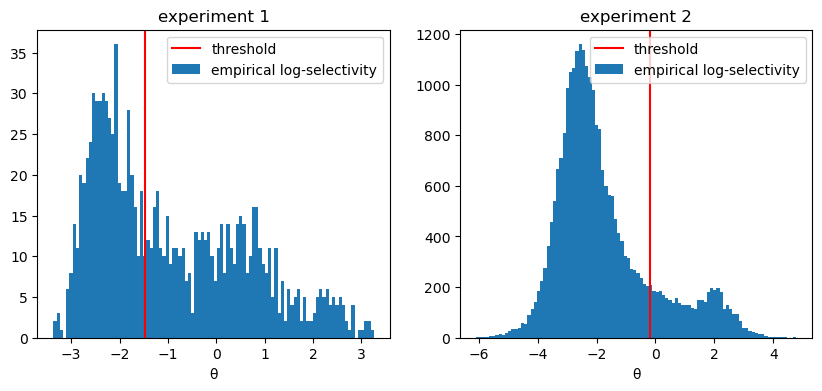

PyObject <matplotlib.legend.Legend object at 0x7f2e2dd02cd0>

In [12]:
fig, ax = subplots(1,2, figsize=(10,4))
ax[1].axvline(threshold_experiment1, color="red")
ax[1].hist(filter(isfinite, θexperiment1), bins=100)
ax[1].set_xlabel("θ")
ax[1].set_title("experiment 1")
ax[1].legend(["threshold", "empirical log-selectivity"])

ax[2].axvline(threshold_experiment2, color="red")
ax[2].hist(filter(isfinite, θexperiment2), bins=100)
ax[2].set_xlabel("θ")
ax[2].set_title("experiment 2")
ax[2].legend(["threshold", "empirical log-selectivity"])

# CNN

In [ ]:
file_cnn = BSON.load("../cnn_models/train_experiment1_thrfit.bson")
model_cnn = file_cnn[:model]
history_cnn = file_cnn[:history]

In [ ]:
plot(get(history_cnn, :training_loss)...)
title("training")
xlabel("epochs")
ylabel("loss");

In [ ]:
logits_experiment1 = model_cnn(sequences_experiment1) |> x -> x[2,:] .- x[1,:];

In [ ]:
logits_experiment2 = model_cnn(sequences_experiment2) |> x -> x[2,:] .- x[1,:];

In [ ]:
fig, ax = subplots(1,2, figsize=(10,4))

plot_density(θexperiment1, logits_experiment1, ax[1], filter=false)
ax[1].set_title("experiment 1 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("logits");

plot_density(θexperiment2, logits_experiment2, ax[2], filter=true)
ax[2].set_title("experiment 2 (test), ρ=$(round(cor_sp(θexperiment2, logits_experiment2), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("logits");

In [ ]:
println("training accuracy: ",
compute_accuracy(logits_experiment1, 0.0, θexperiment1, threshold_experiment1))

In [ ]:
println("test accuracy: ",
compute_accuracy(logits_experiment2, 0.0, θexperiment2, threshold_experiment2))

In [ ]:
true_pos_cnn, false_pos_cnn = roc(logits_experiment2, θexperiment2, threshold_experiment2);

In [ ]:
auc_val_cnn = auc(false_pos_cnn, true_pos_cnn) |> mean
println("AUC: ", auc_val_cnn)

In [ ]:
plot(false_pos_cnn, true_pos_cnn)
title("ROC. Experiment 2 prediction. \n (Neural Network model)")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_cnn, digits=2))"])

In [ ]:
println("confusion matrix \n")
confusion_matrix(logits_experiment2, 0.0, θexperiment2, threshold_experiment2)

# PhageTree

In [13]:
file_phagetree = BSON.load("../phagetree_models/train_experiment1_b256_better.bson")
model_pt = file_phagetree[:model]
history_pt = file_phagetree[:history]

MVHistory{ValueHistories.History}
  :loglikelihood_batch => 3000 elements {Int64,Float64}
  :loglikelihood => 600 elements {Int64,Float64}
  :epoch => 3000 elements {Int64,Int64}

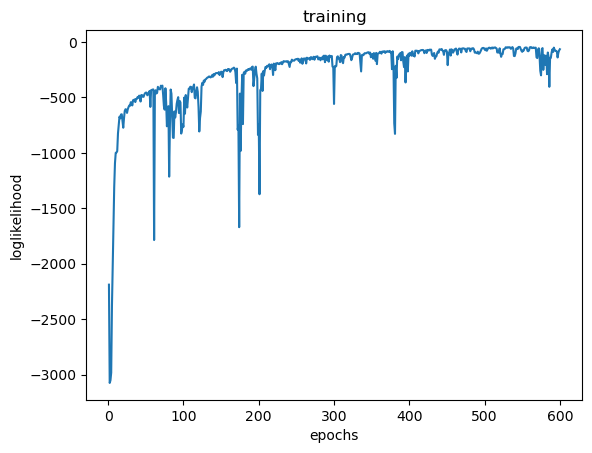

In [14]:
plot(get(history_pt, :loglikelihood)...)
title("training")
xlabel("epochs")
ylabel("loglikelihood");

In [15]:
ls_experiment1 = vec(log_selectivities(model_pt, data_experiment1));

In [16]:
ls_experiment2 = vec(log_selectivities(model_pt, data_experiment2))
ls_experiment2_filtered = ls_experiment2[data_experiment2.counts[:,1].>=100];

In [17]:
θexperiment1_pt = vec(log_selectivities(data_experiment1));

In [18]:
θexperiment2_pt = vec(log_selectivities(data_experiment2));

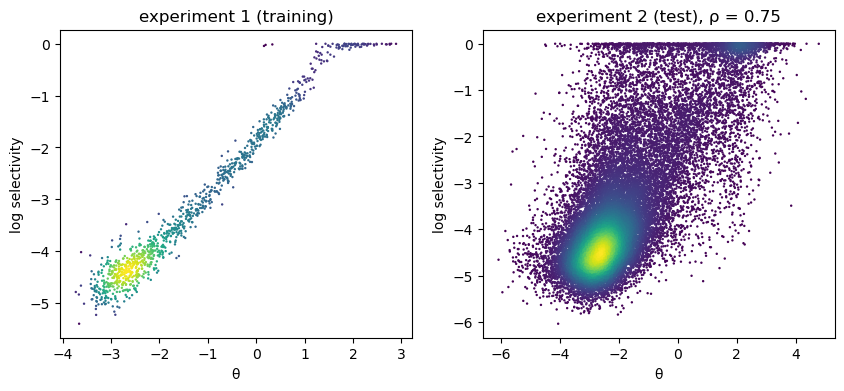

PyObject Text(446.72727272727263, 0.5, 'log selectivity')

In [19]:
fig, ax = subplots(1,2, figsize=(10,4))

plot_density(θexperiment1_pt, ls_experiment1, ax[1])
ax[1].set_title("experiment 1 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("log selectivity")

plot_density(θexperiment2, ls_experiment2_filtered, ax[2], filter=true)
ax[2].set_title("experiment 2 (test), ρ = $(round(cor_sp(θexperiment2, ls_experiment2_filtered), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("log selectivity")

In [20]:
true_pos_pt, false_pos_pt = roc(ls_experiment2_filtered, θexperiment2, threshold_experiment2);

In [21]:
auc_val_pt = auc(false_pos_pt, true_pos_pt) |> mean
println("AUC: ", auc_val_pt)

AUC: 0.9311918387140675


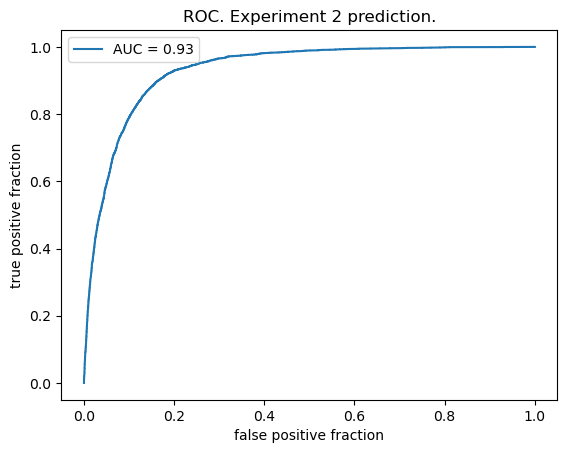

PyObject <matplotlib.legend.Legend object at 0x7f2e1d8ad7f0>

In [22]:
plot(false_pos_pt, true_pos_pt)
title("ROC. Experiment 2 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_pt, digits=2))"])

In [23]:
plot(false_pos_pt, true_pos_pt, color="#ff7f0e")
plot(false_pos_cnn, true_pos_cnn, color="#1f77b4")
title("ROC. Experiment 2 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["Biophysical model AUC = $(round(auc_val_pt, digits=2))", "Binary classifier AUC = $(round(auc_val_cnn, digits=2))"])
#savefig("../figures/exp2_roc.pdf", format="pdf")

LoadError: UndefVarError: false_pos_cnn not defined

In [24]:
ls_threshold = optimal_threshold(ls_experiment2_filtered, true_pos_pt, false_pos_pt)

-2.7973821593263573

In [25]:
println("test accuracy: ",
compute_accuracy(ls_experiment2_filtered, ls_threshold, θexperiment2, threshold_experiment2))

test accuracy: 0.849693483690305


In [26]:
println("confusion matrix \n")
confusion_mat_gscore_exp2=confusion_matrix(ls_experiment2_filtered, ls_threshold, θexperiment2, threshold_experiment2)

confusion matrix 

TP: 3955	 FN: 463
FP: 3509	 TN: 18499

(tpr = 0.8952014486192847, fpr = 0.15944202108324246)

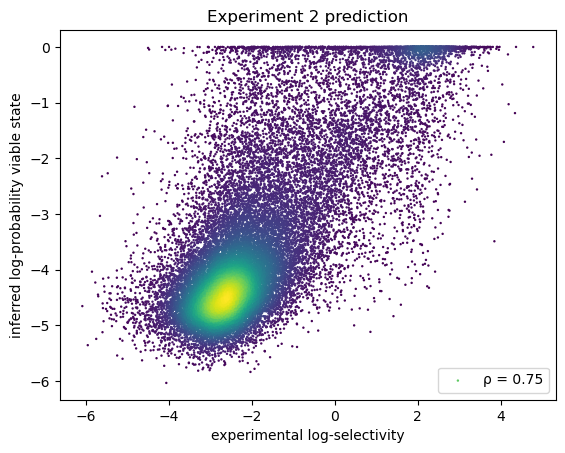

PyObject <matplotlib.legend.Legend object at 0x7f2e1d8c7ee0>

In [27]:
plot_density(θexperiment2, ls_experiment2_filtered, filter=true)
title("Experiment 2 prediction")
xlabel("experimental log-selectivity")
ylabel("inferred log-probability viable state")
legend(["ρ = $(round(cor_sp(θexperiment2, ls_experiment2_filtered), digits=2))"])
#savefig("../figures/exp2_prediction.pdf", format="pdf")

### Choosing the threshold in an unsupervised manner

In [28]:
energies_exp1 = energies(data_experiment1.sequences, model_pt.states[2])
energies_exp2 = energies(data_experiment2.sequences[:,:,data_experiment2.counts[:,1].>= 100], model_pt.states[2]);

In [29]:
μeff = model_pt.μ[2,1] - model_pt.μ[1,1]

0.009192245092378244

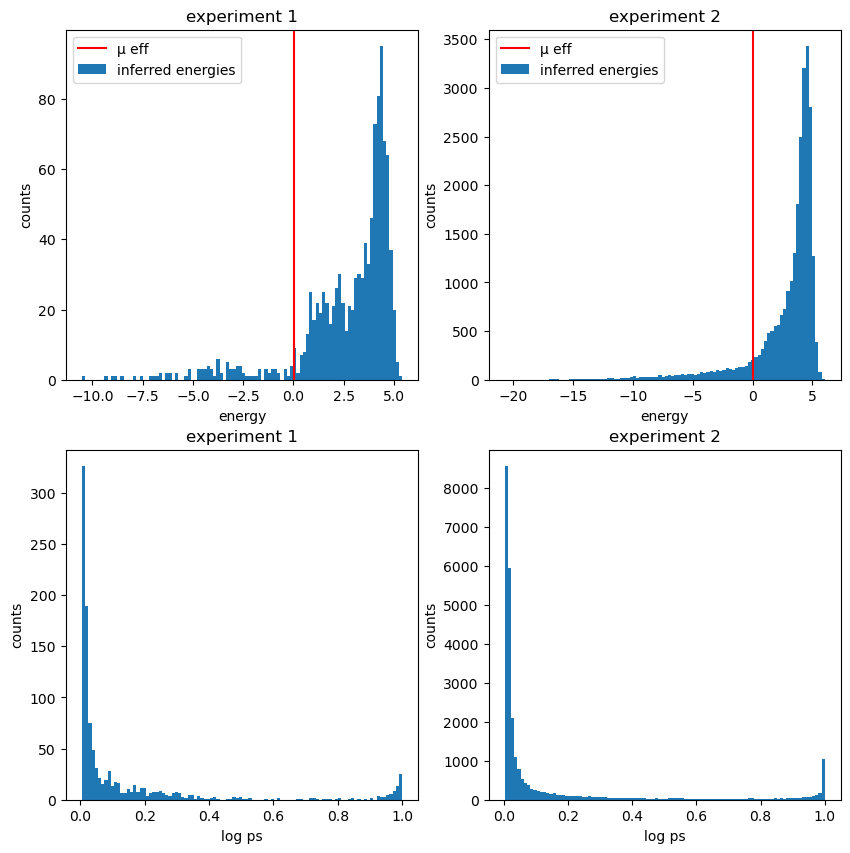

In [30]:
fig, ax = subplots(2,2, figsize=(10,10))
ax[1,1].axvline(μeff, color="red")
ax[1,1].hist(energies_exp1, bins=100)
ax[1,1].set_xlabel("energy")
ax[1,1].set_ylabel("counts")
ax[1,1].set_title("experiment 1")
ax[1,1].legend(["μ eff", "inferred energies"])

ax[1,2].axvline(μeff, color="red")
ax[1,2].hist(energies_exp2, bins=100)
ax[1,2].set_xlabel("energy")
ax[1,2].set_ylabel("counts")
ax[1,2].set_title("experiment 2")
ax[1,2].legend(["μ eff", "inferred energies"])

ax[2,1].hist(exp.(ls_experiment1), bins=100)
ax[2,1].set_xlabel("log ps")
ax[2,1].set_ylabel("counts")
ax[2,1].set_title("experiment 1")

ax[2,2].hist(exp.(ls_experiment2_filtered), bins=100)
ax[2,2].set_xlabel("log ps")
ax[2,2].set_ylabel("counts")
ax[2,2].set_title("experiment 2");

In [31]:
gmm = GMM(2,1)
gmm.μ .+= randn(2,1)
gmm.Σ .*= 1e-1;

In [32]:
em!(gmm, Float64.(reshape(energies_exp2, :, 1)); nIter=120)

120-element Vector{Float64}:
 -Inf
  -2.0397861315469874
  -2.0167769633452
  -2.006123510574338
  -1.997812382310341
  -1.9910652967940528
  -1.9854758570741906
  -1.9808130069691785
  -1.9769384927765623
  -1.9737566929809538
  -1.9711864543321183
  -1.96914843406364
  -1.9675622930816181
   ⋮
  -1.962965576483371
  -1.9629655764833684
  -1.9629655764833696
  -1.9629655764833684
  -1.9629655764833696
  -1.9629655764833678
  -1.9629655764833696
  -1.962965576483369
  -1.9629655764833696
  -1.9629655764833678
  -1.9629655764833696
  -1.9629655764833704

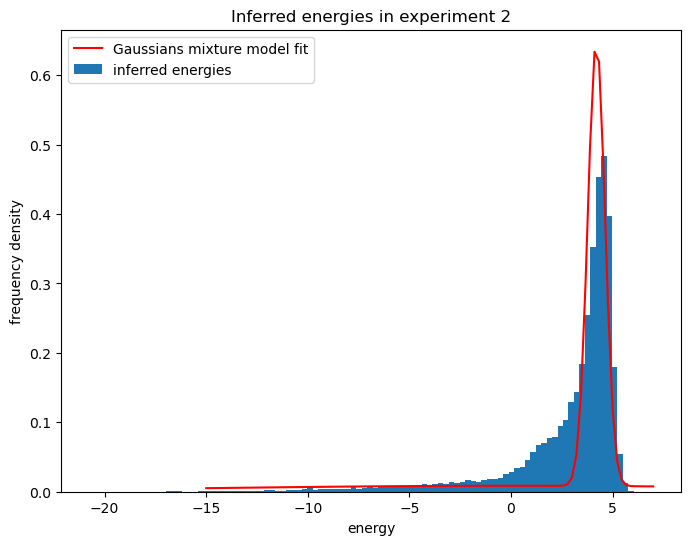

In [43]:
xx = LinRange(-15.0, 7.0, 100)
figure(figsize=(8,6))
hist(energies_exp2, bins=100, density=true)
plot(xx, eval_gmm(gmm, xx), color="red")
#plot(xx, gmm.w[1].*pdf.(Normal(gmm.μ[1,1], gmm.Σ[1,1]), xx))
#plot(xx, gmm.w[2].*pdf.(Normal(gmm.μ[2,1], gmm.Σ[2,1]), xx))
xlabel("energy")
ylabel("frequency density")
legend(["Gaussians mixture model fit", "inferred energies"])
title("Inferred energies in experiment 2")
#yscale(:log)
savefig("../figures/exp2_energy_fit.pdf", format="pdf")

In [ ]:
function find_valley(gmm, resolution::Int)
    xmin = gmm.μ[1,1]
    xmax = gmm.μ[2,1]
    r = LinRange(xmin, xmax, resolution)
    y = eval_gmm(gmm, r)
    xvalley = argmin(y)
    return r[xvalley]
end

In [ ]:
find_valley(gmm, 100)

In [ ]:
unsupervised_energy_threshold = 2.186591448464858

In [ ]:
println("testing accuracy on experiment 2: ",
compute_accuracy(-energies_exp2, -unsupervised_energy_threshold, θexperiment2, threshold_experiment2))

In [ ]:
println("confusion matrix \n")
confusion_mat_unsupervised_exp2 = confusion_matrix(-energies_exp2, -unsupervised_energy_threshold, θexperiment2, threshold_experiment2)

In [ ]:
plot(false_pos_pt, true_pos_pt)
scatter([confusion_mat_unsupervised_exp2.fpr], [confusion_mat_unsupervised_exp2.tpr], s=30, color="red")
scatter([confusion_mat_gscore_exp2.fpr], [confusion_mat_gscore_exp2.tpr], s=30, color="green")
title("ROC. Experiment 2 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["biophysical model ROC (AUC = $(round(auc_val_pt, digits=2)))", "optimal threshold gaussian fit", "optimal threshold from g-score"])
#savefig("../figures/exp2_roc_points.pdf", format="pdf")

# Distance analysis

In [ ]:
file_exp1 = load("../my_data/data_experiment1.jld2")

In [ ]:
wt_aa = file_exp1["wt_aa"]

In [ ]:
sequences_string_experiment2 = onehot2string(sequences_experiment2, channel=true);

In [ ]:
distances_cnn = map(x->evaluate(Levenshtein(), x, wt_aa), sequences_string_experiment2);

In [ ]:
dmin, dmax = extrema(distances_cnn)

In [ ]:
accuracy_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        accuracy_distance[i] = NaN
        continue
    end
    accuracy_distance[i] = compute_accuracy(logits_experiment2[idx], 0.0, θexperiment2[idx], threshold_experiment2)
end

In [ ]:
accuracy_distance_energy = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        accuracy_distance_energy[i] = NaN
        continue
    end
    accuracy_distance_energy[i] = compute_accuracy(-energies_exp2[idx], -unsupervised_energy_threshold, 
        θexperiment2[idx], threshold_experiment2)
end

In [ ]:
pearson_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        pearson_distance[i] = NaN
        continue
    end
    pearson_distance[i] = cor_sp(θexperiment2[idx], ls_experiment2_filtered[idx])
end

In [ ]:
viable_frac = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        viable_frac[i] = NaN
        continue
    end
    viable_frac[i] = sum(θexperiment2[idx] .>= threshold_experiment2)/length(idx)
end

In [ ]:
plot(dmin:dmax, accuracy_distance, marker="o")
plot(dmin:dmax, accuracy_distance_energy, marker="p")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["binary classifier", "biophysical model", "viable fraction"])
ylabel("accuracy / fraction")
xlabel("distance from WT")
title("Experiment 2. Robustness and diversity.")
savefig("../figures/exp2_distance_accuracy.pdf", format="pdf")

In [ ]:
plot(dmin:dmax, pearson_distance, marker="o", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["biophysical model", "viable fraction"])
ylabel("Pearson / fraction")
xlabel("distance from WT")
title("Experiment 2. Robustness and diversity.")
savefig("../figures/exp2_distance_pearson.pdf", format="pdf")